In [1]:
from pathlib import Path

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchinfo
import torchvision
from albumentations.pytorch.transforms import ToTensorV2
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap
from torchlake.common.utils.plot import plot_grids
from torchlake.semantic_segmentation.datasets.voc import (LABEL_COLORS,
                                                          VocSegmentation)
from torchlake.semantic_segmentation.models import UNet
from tqdm import tqdm

# setting

In [2]:
artifacts_path = Path("../../artifacts/unet")
data_path = Path("../../data")

In [3]:
device = torch.device("cuda:0")

# Data

In [4]:
BATCH_SIZE = 16
IMAGE_SIZE = 224

In [5]:
preprocess = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1), # in feature extractor
        ToTensorV2(),
    ]
)

In [6]:
train_dataset = VocSegmentation(
    data_path.as_posix(),
    transform=preprocess,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

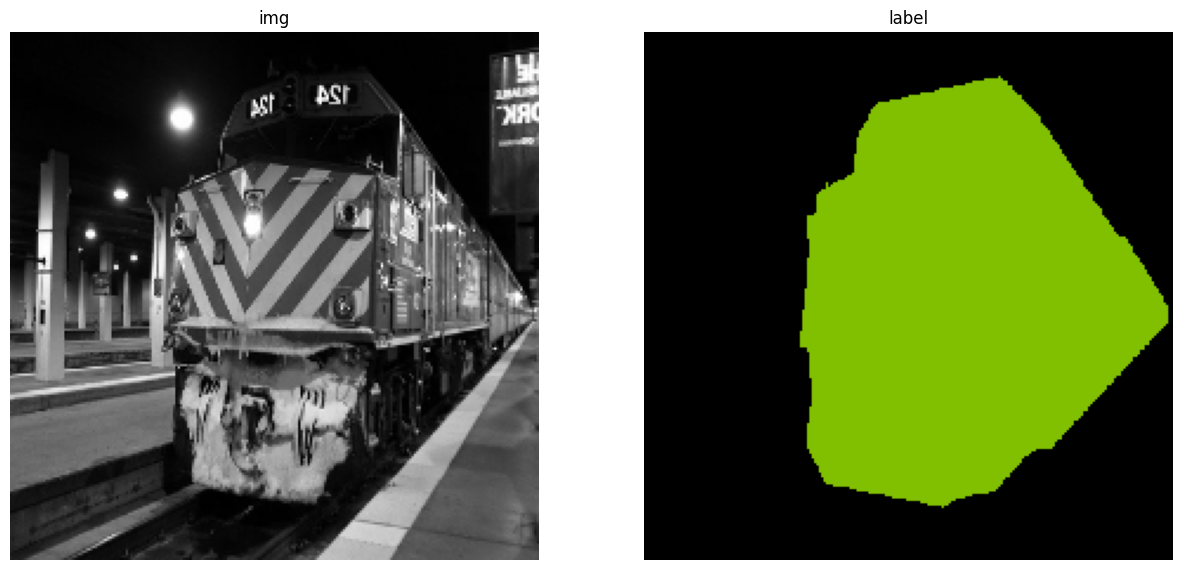

In [8]:
interest_pic = 8
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

# Model

In [9]:
model = UNet(20+1).to(device)

In [10]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
UNet                                     --
├─DoubleConv: 1-1                        --
│    └─ConvBnRelu: 2-1                   --
│    │    └─Conv2d: 3-1                  1,728
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    └─ConvBnRelu: 2-2                   --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    │    └─ReLU: 3-6                    --
├─DownSampling: 1-2                      --
│    └─MaxPool2d: 2-3                    --
│    └─DoubleConv: 2-4                   --
│    │    └─ConvBnRelu: 3-7              73,984
│    │    └─ConvBnRelu: 3-8              147,712
├─DownSampling: 1-3                      --
│    └─MaxPool2d: 2-5                    --
│    └─DoubleConv: 2-6                   --
│    │    └─ConvBnRelu: 3-9              295,424
│    │    └─ConvBnRelu: 3-10             590,336
├─DownSampling: 1-4                      --

# training

In [11]:
cls_show = torch.cat([label.unique() for _, label in tqdm(train_dataset)])

  0%|          | 0/2913 [00:00<?, ?it/s]

100%|██████████| 2913/2913 [00:18<00:00, 161.41it/s]


In [12]:
cls_count = np.array([cls_show.eq(c).sum().item() for c in range(21)])
cls_harmonic = (1 / cls_count) / sum(1 / cls_count)
cls_freq_inverse = 1 / (cls_count / sum(cls_count))

In [13]:
criterion = nn.CrossEntropyLoss(
    weight=torch.from_numpy(cls_harmonic).float().to(device)
)
optimizer = torch.optim.Adam(model.parameters())

In [14]:
EPOCHES = 10
acc_iter = 1

In [15]:
model.train()
for e in range(EPOCHES):
    running_loss = 0.0
    count_acc = 0  # gradient accumulation
    optimizer.zero_grad()
    for img, label in tqdm(train_loader):
        img = img.to(device)
        label = label.long().to(device)

        output = model(img).float()
        loss = criterion(output, label) / acc_iter
        loss.backward()
        count_acc += 1

        if count_acc % acc_iter == 0:
            optimizer.step()
            optimizer.zero_grad()
            count_acc = 0

        running_loss += loss.item()
    print(f"epoch {e+1}: {running_loss/len(train_dataset)}")

100%|██████████| 182/182 [01:10<00:00,  2.57it/s]


epoch 1: 0.17340141671898027


100%|██████████| 182/182 [01:13<00:00,  2.49it/s]


epoch 2: 0.16296230261161324


100%|██████████| 182/182 [01:12<00:00,  2.51it/s]


epoch 3: 0.15788575754188566


100%|██████████| 182/182 [01:12<00:00,  2.52it/s]


epoch 4: 0.15417246944585944


100%|██████████| 182/182 [01:11<00:00,  2.54it/s]


epoch 5: 0.15123065054887275


100%|██████████| 182/182 [01:12<00:00,  2.52it/s]


epoch 6: 0.14876191623424526


100%|██████████| 182/182 [01:12<00:00,  2.51it/s]


epoch 7: 0.1467921102411183


100%|██████████| 182/182 [01:07<00:00,  2.69it/s]


epoch 8: 0.1447463049906617


100%|██████████| 182/182 [01:06<00:00,  2.74it/s]


epoch 9: 0.14507456837427235


100%|██████████| 182/182 [01:07<00:00,  2.71it/s]

epoch 10: 0.14152808930920524


In [ ]:
model_path = artifacts_path.joinpath('unet.pth')

In [39]:
torch.save(model.state_dict(), model_path.as_posix())

In [14]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>

# Prediction

In [36]:
def draw_comparison(img: torch.Tensor, label: torch.Tensor, pred: torch.Tensor):
    plot_grids(
        [
            img_tensor_to_np(img),
            decode_segmap(img_tensor_to_np(label).squeeze(-1), LABEL_COLORS),
            decode_segmap(img_tensor_to_np(pred).squeeze(-1), LABEL_COLORS),
        ],
        ["img", "label", "prediction"],
        1,
        3,
        figsize=(15, 15),
    )

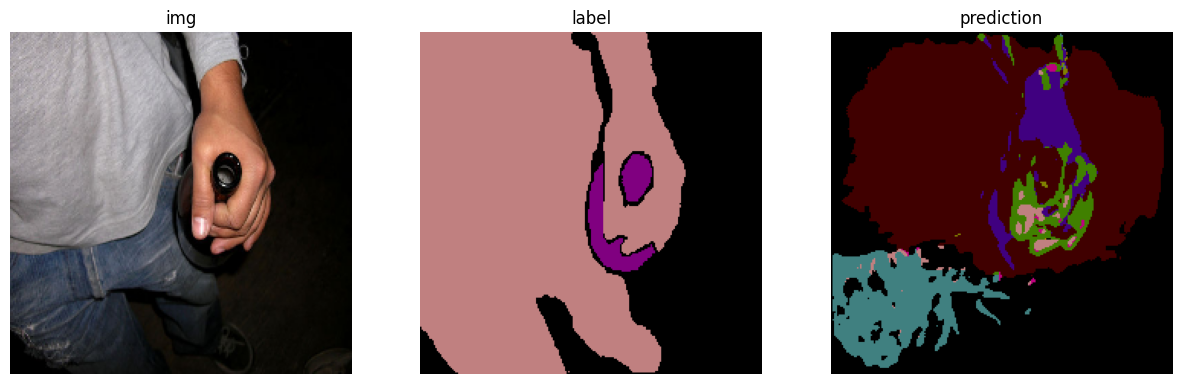

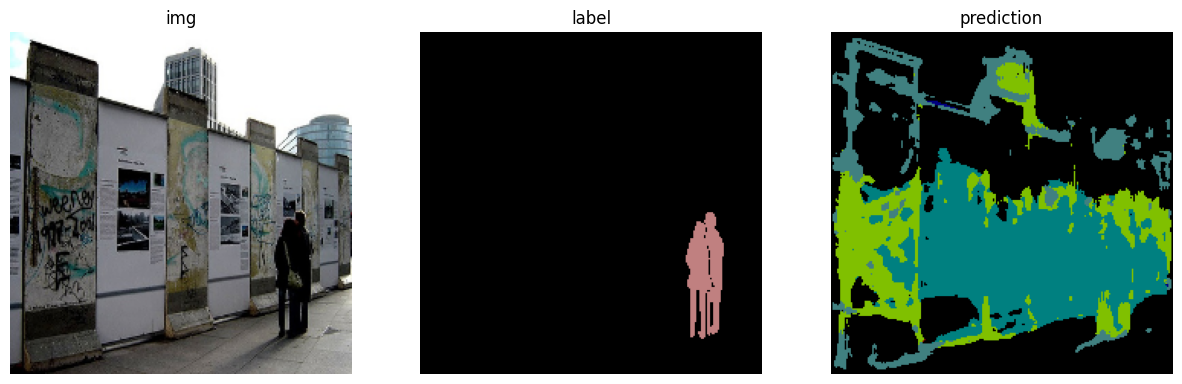

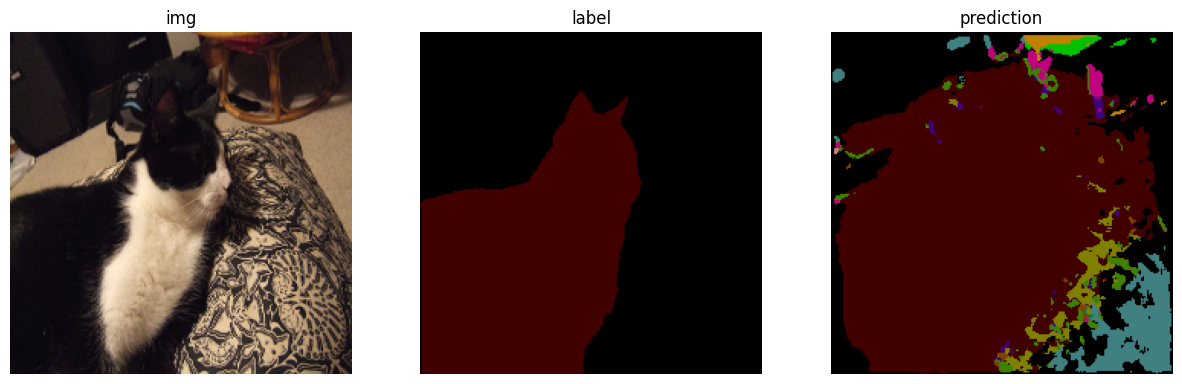

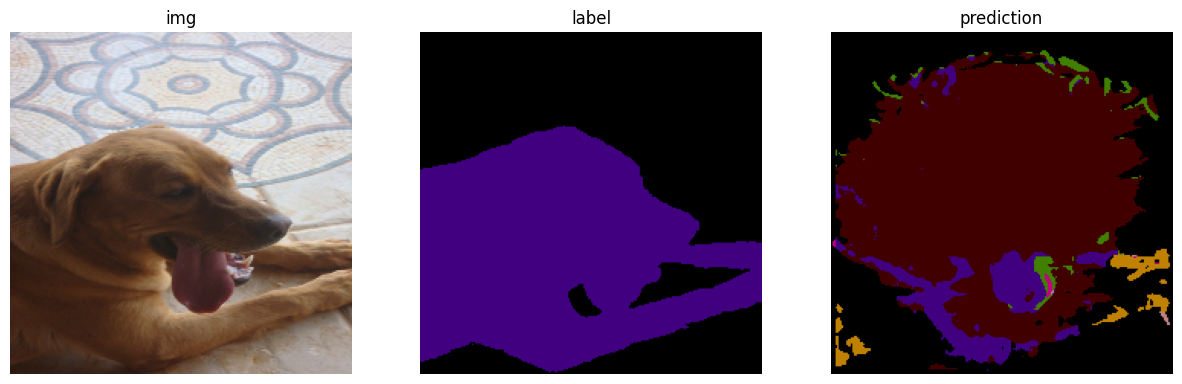

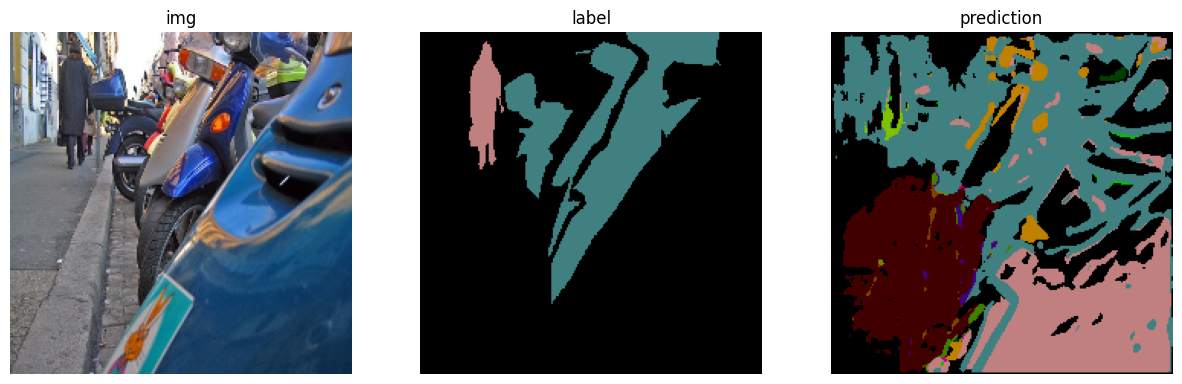

In [37]:
for i in np.random.randint(0, len(train_dataset), 5):
    interest_pic, interest_label = train_dataset[i]

    model.eval()
    with torch.no_grad():
        interest_pic = interest_pic.unsqueeze(0).to(device)
        interest_label = interest_label.unsqueeze(0).to(device)
        output = model(interest_pic).argmax(dim=1)

        draw_comparison(
            interest_pic,
            interest_label,
            output,
        )

## 比較 FCN

In [38]:
fcn = torchvision.models.segmentation.fcn_resnet50(weight='DEFAULT').eval()

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\research\pytorch-implementations\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to D://research/pytorch-implementations/cache\hub\checkpoints\fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [02:06<00:00, 1.12MB/s] 


In [39]:
fcn_out = fcn(train_dataset[8][0].unsqueeze(0))['out'].argmax(dim=1).squeeze(0)

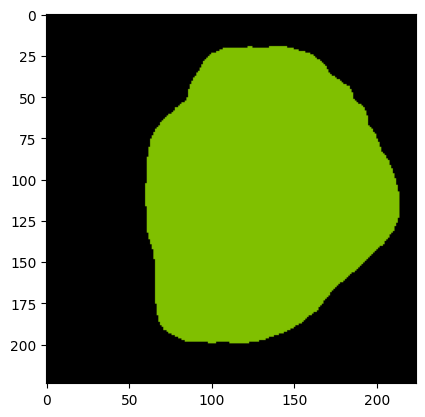

In [41]:
# 一個成功的案例，官方也會失敗 XDD
# one success example, even official failed often lol
plt.imshow(decode_segmap(fcn_out, LABEL_COLORS))